In [ ]:
import pandas as pd
students_df = pd.read_csv('./resources/3.school/students.csv')
students_df

In [ ]:
for name in students_df.columns:
    print(f'- {name} -------------------------')
    print(students_df[name].value_counts())

In [ ]:
%matplotlib inline

In [ ]:
students_df['score'].hist()

In [ ]:
pairs_df = pd.read_csv('./resources/3.school/student_pairs.csv')
pairs_df

### Requirements

- You need to
    1. assign all students to a class
    2. create a class consists of gteq 39 and lteq 40 (there are 8 classes and 318 members)
    3. create a class consists of lteq 20 male and lteq 20 female (158 male and 160 female)
    4. make the average score of a class within ±10 from average of whole students (average score 303.6)
    5. assign more than 2 students with leadership (17 leaders)
    6. assign less than 1 students who need support (4 students)
    7. avoid assign indicated student pairs to same class

In [ ]:
import pulp
problem = pulp.LpProblem("ClassAssignment", pulp.LpMaximize)

### Requirement 1

- Students: S
- Classes: C
- Variables: X `X[s in S][c in C] ∈ (0, 1)`
- Restriction: For every student s in S, `sum([X[s][c] for c in C]) == 1`

In [ ]:
S = students_df['student_id'].tolist()
S[:10]

In [ ]:
import string
string.ascii_uppercase

In [ ]:
C = list(string.ascii_uppercase[:8])
C

In [ ]:
sc = [(s,c) for s in S for c in C]
sc[:10]

In [ ]:
X = pulp.LpVariable.dicts('X', sc, cat=pulp.LpBinary)

In [ ]:
for s in S:
    problem += pulp.lpSum([X[s,c] for c in C]) == 1

### Requirement 2

- For every c in C
    - `sum([X[s][c] for s in S]) >= 39`
    - `sum([X[s][c] for s in S]) <= 40`

In [ ]:
for c in C:
    problem += pulp.lpSum([X[s,c] for s in S]) >= 39
    problem += pulp.lpSum([X[s,c] for s in S]) <= 40

### Requirement 3

- For every c in C
    - `sum([X[s][c] for s in S_male]) <= 20`
    - `sum([X[s][c] for s in S_female]) <= 20`


In [ ]:
S_male = students_df[students_df['gender'] == 1]['student_id'].tolist()
len(S_male)

In [ ]:
S_female = students_df[students_df['gender'] == 0]['student_id'].tolist()
len(S_female)

In [ ]:
for c in C:
    problem += pulp.lpSum(X[s,c] for s in S_male) <= 20
    problem += pulp.lpSum(X[s,c] for s in S_female) <= 20

### Requirement 4

- Constants
    - Score a student: `score[s]`
    - Average score: mean_score
- Restriction
    - For every c in C
        - mean_score_of_class = sum([score[s] for s in (S belongs c)]) / sum([X[s,c] for s in S])
          - Remember `X[s,c] ∈ (0, 1)`. Then `sum([X[s,c] for s in S])` will be number of students.
        - mean_score - 10 <= mean_score_of_class
        - mean_score_of_class <= mean_score + 10

This formula is not linear
`mean_score - 10 <= sum([score[s] for s in (S belongs c)]) / sum([X[s,c] for s in S])`

So change to linear formula
=> `(mean_score - 10) * (sum([X[s,c] for s in S])) <= sum([score[s] for s in (S belongs c)])`

And to describe sum of score of a class, use `X[s,c] ∈ (0, 1)`.
=> `sum([(score[s] * X[s,c]) for s in S])`

If a student belongs to the class, `X[s,c]` returns 1 and score would be added to the sum.
If a student doesn't belong to the class, `X[s,c]` returns 0 and 0 would be added to the sum.


In [ ]:
mean_score = students_df['score'].mean()
mean_score

In [ ]:
score = { student.student_id: student.score for student in students_df.itertuples() }

In [ ]:
type(X[1, 'A'])

In [ ]:
for c in C:
    problem += (mean_score - 10) * pulp.lpSum(X[s,c] for s in S) <= pulp.lpSum(X[s,c] * score[s] for s in S)
    problem += pulp.lpSum(X[s,c] * score[s] for s in S) <= (mean_score + 10) * pulp.lpSum(X[s,c] for s in S)

### Requirement 5

Assign at least two students with leadership
```
for c in C:
    sum([X[s,c] for s in S_leader]) >= 2
```

In [ ]:
S_leader = students_df[students_df['leader_flag'] == 1]['student_id'].tolist()
S_leader

In [ ]:
for c in C:
    problem += pulp.lpSum(X[s,c] for s in S_leader) >= 2

### Requirement 6

Don't assign more than one student needs support
```
for c in C:
    sum([X[s,c] for s in S_support]) <= 1
```

In [ ]:
S_support = students_df[students_df['support_flag'] == 1]['student_id'].tolist()
S_support

In [ ]:
for c in C:
    problem += pulp.lpSum(X[s,c] for s in S_support) <= 1

### Requirement 7

Don't assign any indicated pair of students in a same class

```
pairs = [
    [1,2],
    [3,4],
]
```

```
for c in C:
    for p in pairs
        # sum([X[s,c] for s in pairs]) <= 1
        X[p[0], c] + X[p[1], c] <= 1
```

In [ ]:
pairs_df

In [ ]:
pairs = [(p.student_id1, p.student_id2) for p in pairs_df.itertuples()]
pairs

In [ ]:
for c in C:
    for id1, id2 in pairs:
        problem += X[id1,c] + X[id2,c] <= 1

In [ ]:
status = problem.solve()
print(pulp.LpStatus[status])

In [ ]:
Result = {}
for c in C:
    Result[c] = [s for s in S if X[s,c].value() == 1]

In [ ]:
for c, students in Result.items():
    print('Class:', c)
    print('Number of students:', len(students))
    print('Students:', students)

## Check requirements

### Requirement 1: We need to provide every student to one class

In [ ]:
for s in S:
    assigned_class = [X[s,c].value() for c in C if X[s,c].value() == 1]
    if len(assigned_class) != 1:
        print('error:', s, assigned_class)

In [ ]:
result_df = students_df.copy()


In [ ]:
result_df['assigned_class'] = result_df['student_id'].map({ s:c for s in S for c in C if X[s,c].value() == 1 })
result_df

### Requirement 2: Number of students in a class

In [ ]:
result_df['assigned_class'].value_counts()

### Requirement 3: Number of male and female students in a class

In [ ]:
result_df.groupby(['assigned_class', 'gender'])['student_id'].count()

### Requirement 4: Mean score

In [ ]:
result_df.groupby(['assigned_class'])['score'].mean()

In [ ]:
mean_score

In [ ]:
mean_score - result_df.groupby(['assigned_class'])['score'].mean().min()

In [ ]:
mean_score - result_df.groupby(['assigned_class'])['score'].mean().max()

### Requirement 5: Leaders

In [ ]:
result_df.groupby(['assigned_class'])['leader_flag'].sum()

### Requirement 6: Support

In [ ]:
result_df.groupby(['assigned_class'])['support_flag'].sum()

### Requirement 7: Pair

In [ ]:
for id1, id2 in pairs:
    class1 = result_df[result_df['student_id'] == id1]['assigned_class']
    class2 = result_df[result_df['student_id'] == id2]['assigned_class']
    print(f"{id1}: {class1.tolist()[0]}, {id2}: {class2.tolist()[0]}")

## Improve distribution of score

In [104]:
import matplotlib.pyplot as plt

def plot_score_dist(df_filter):
    fig = plt.figure(figsize=(12, 20))
    for i, c in enumerate(C):
        cls_df = df_filter(c)
        ax = fig.add_subplot(4
                             , 2
                             , i+1
                             , xlabel='score'
                             , ylabel='num'
                             , xlim=(0,500)
                             , ylim=(0,20)
                             , title=f"Class:{c}")
        ax.hist(cls_df['score'], bins=range(0,500,40))

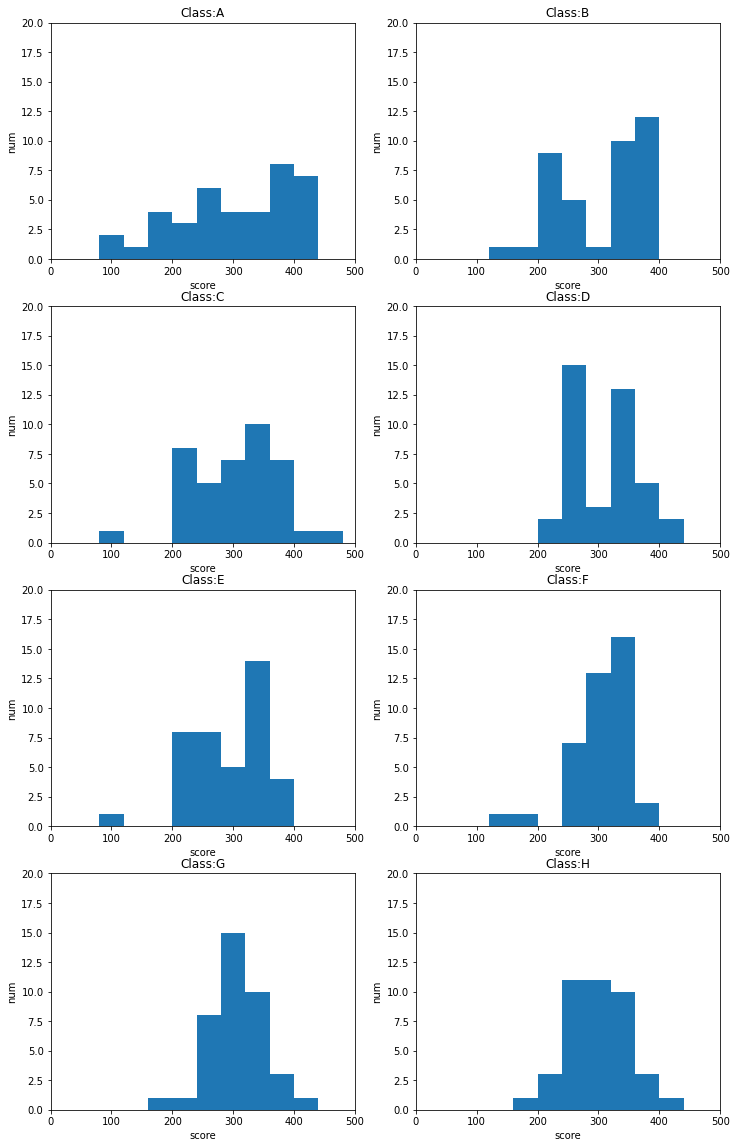

In [105]:
plot_score_dist(lambda x: result_df[result_df['assigned_class'] == x])

We want to make distribution of scores similar between classes.

In [ ]:
students_df['score_rank'] = students_df['score'].rank(ascending=False, method='first')
students_df['score_rank']

In [ ]:
students_df['score_rank'].map(lambda x: int(x) % 8).map(lambda x: C[x])

In [ ]:
students_df['initial_class'] = students_df['score_rank'].map(lambda x: int(x) % 8).map(lambda x: C[x])
students_df['initial_class']

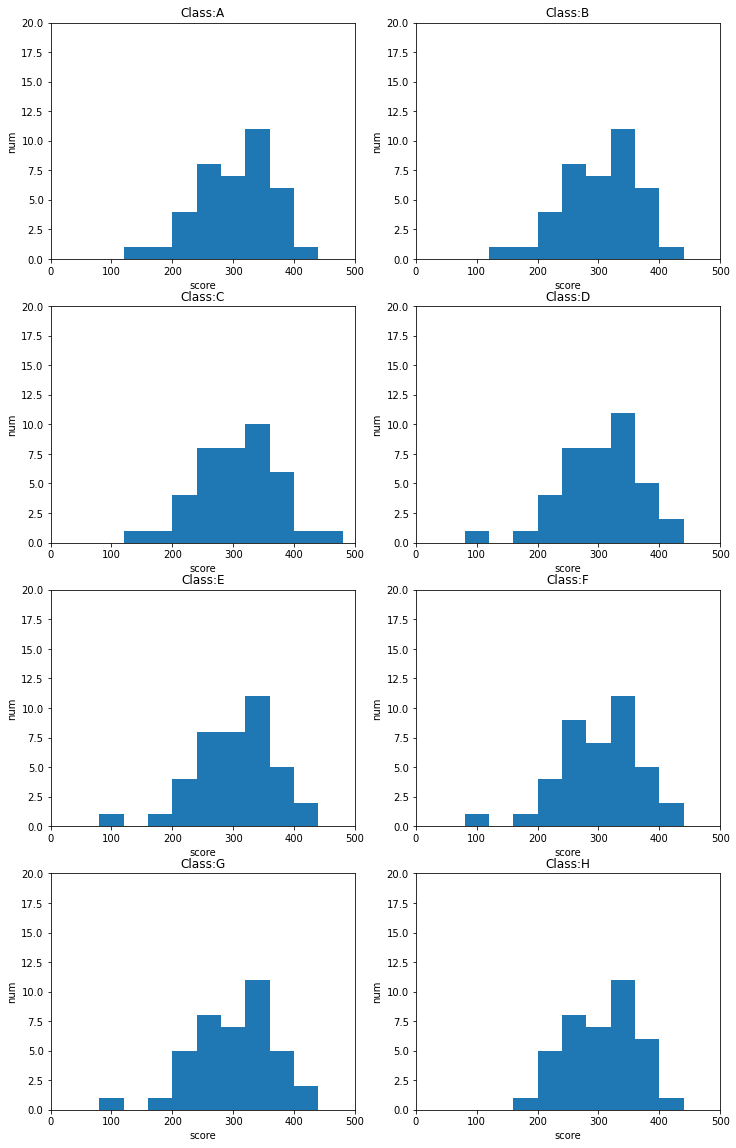

In [106]:
plot_score_dist(lambda x: students_df[students_df['initial_class'] == x])

In [ ]:
init_flag = {(s,c): 0 for s in S for c in C}
pd.Series(init_flag)

In [ ]:
for row in students_df.itertuples():
    init_flag[row.student_id, row.initial_class] = 1

Initialize LP problem again

In [96]:
import pulp
problem2 = pulp.LpProblem("ClassAssignment", pulp.LpMaximize)

# Variables
import string
S = students_df['student_id'].tolist()
C = list(string.ascii_uppercase[:8])
sc = [(s,c) for s in S for c in C]
X = pulp.LpVariable.dicts('X', sc, cat=pulp.LpBinary)

### Requirement 1
for s in S:
    problem2 += pulp.lpSum([X[s,c] for c in C]) == 1

### Requirement 2
for c in C:
    problem2 += pulp.lpSum([X[s,c] for s in S]) >= 39
    problem2 += pulp.lpSum([X[s,c] for s in S]) <= 40

### Requirement 3
S_male = students_df[students_df['gender'] == 1]['student_id'].tolist()
S_female = students_df[students_df['gender'] == 0]['student_id'].tolist()

for c in C:
    problem2 += pulp.lpSum(X[s,c] for s in S_male) <= 20
    problem2 += pulp.lpSum(X[s,c] for s in S_female) <= 20

### Requirement 4

mean_score = students_df['score'].mean()
score = { student.student_id: student.score for student in students_df.itertuples() }
for c in C:
    problem2 += (mean_score - 10) * pulp.lpSum(X[s,c] for s in S) <= pulp.lpSum(X[s,c] * score[s] for s in S)
    problem2 += pulp.lpSum(X[s,c] * score[s] for s in S) <= (mean_score + 10) * pulp.lpSum(X[s,c] for s in S)

### Requirement 5

S_leader = students_df[students_df['leader_flag'] == 1]['student_id'].tolist()
for c in C:
    problem2 += pulp.lpSum(X[s,c] for s in S_leader) >= 2


### Requirement 6
S_support = students_df[students_df['support_flag'] == 1]['student_id'].tolist()
for c in C:
    problem2 += pulp.lpSum(X[s,c] for s in S_support) <= 1

### Requirement 7
pairs = [(p.student_id1, p.student_id2) for p in pairs_df.itertuples()]
for c in C:
    for id1, id2 in pairs:
        problem2 += X[id1,c] + X[id2,c] <= 1


In [97]:
# add objective formula: maximize cases of "assigned class = initial class"
problem2 += pulp.lpSum(X[s,c] * init_flag[s,c] for s,c in sc)

In [98]:
status = problem2.solve()
print(pulp.LpStatus[status])

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/ta.nakamura/src/github.com/na9amura/try-or-tools/venv/lib/python3.9/site-packages/pulp/apis/../solverdir/cbc/osx/64/cbc /var/folders/y3/x37rtt0s6fn4r9r7__s24rzc0000gp/T/ee79763337b14f37b7728bdbd581f4b9-pulp.mps max timeMode elapsed branch printingOptions all solution /var/folders/y3/x37rtt0s6fn4r9r7__s24rzc0000gp/T/ee79763337b14f37b7728bdbd581f4b9-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 411 COLUMNS
At line 21298 RHS
At line 21705 BOUNDS
At line 24250 ENDATA
Problem MODEL has 406 rows, 2544 columns and 15480 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 298 - 0.01 seconds
Cgl0005I 318 SOS with 2544 members
Cgl0004I processed model has 398 rows, 2544 columns (2544 integer (2544 of which binary)) and 12936 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initi

In [109]:
result_df2 = students_df.copy()
result_df2['assigned_class'] = result_df2['student_id'].map({ s:c for s in S for c in C if X[s,c].value() == 1 })
result_df2

,student_id,gender,leader_flag,support_flag,score,score_rank,initial_class,assigned_class
0,1,0,0,0,335,109.0,F,F
1,2,1,0,0,379,38.0,G,A
2,3,0,0,0,350,79.0,H,H
3,4,0,0,0,301,172.0,E,E
4,5,1,0,0,317,147.0,D,D
...,...,...,...,...,...,...,...,...
313,314,0,0,0,244,263.0,H,G
314,315,1,0,0,309,162.0,C,C
315,316,0,0,0,239,272.0,A,A
316,317,1,0,0,356,63.0,H,H


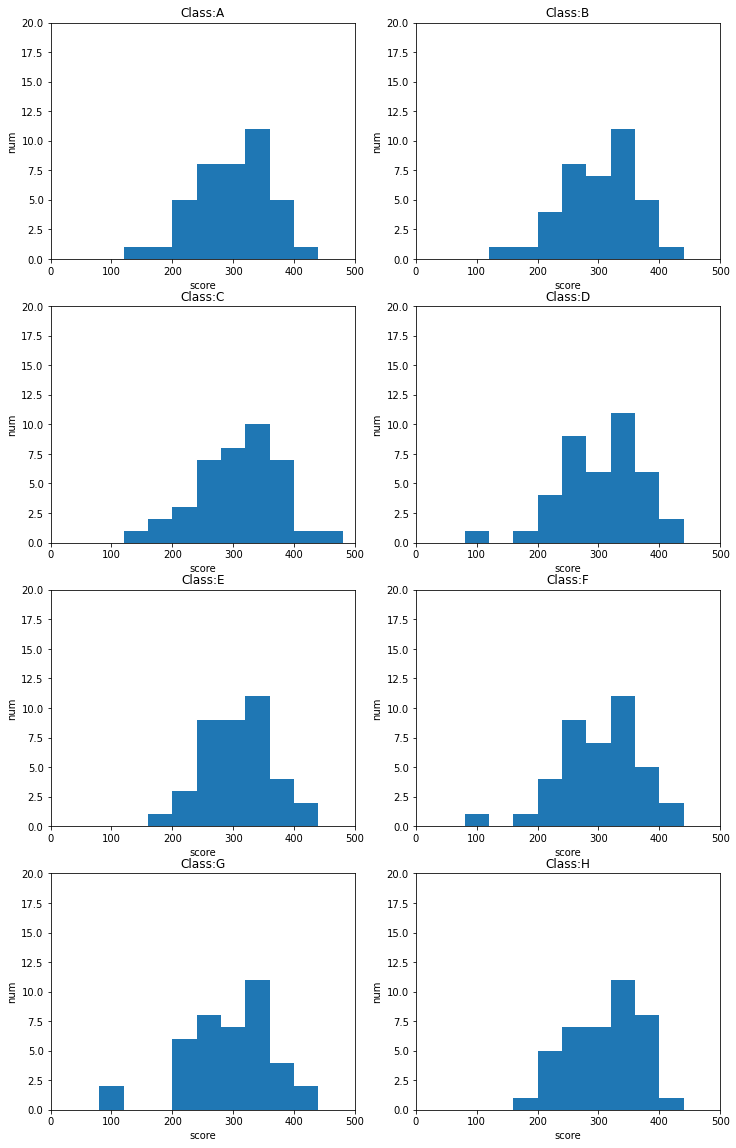

In [110]:
plot_score_dist(lambda x: result_df2[result_df2['assigned_class'] == x])
